## Gaussian Process


Before learning what is Gaussian Process, let's first understant what GP gives us. Imagine that we are doing some reports and we have to interview people with targeted people, let's say, cancer patients. In order to interview a patient, we have to make a phone call, schedule an interview which takes 30 minutes. 30 minutes is a big number, not any patient would like to have this interview. what's next? In this interview, the patients will have to test on a new medical device which has to be rented from a medical company. The renting fee is 1000USD/person. This means that when we need to collect data from patients, not only it costs time(asking for permision and scheduling) and money(renting fee). If we have time and money, we could just call all the patients, schedual the interview through out the year and spend tons of money to rent the device. But, this is just not the case. Thus our goal becomes that we have to carefully select patients, so that with the least amount of time and money spent, we could complete our report. This is where GPs are used.

Gps allow us to understand the uncertainty of our model. It gives us the information that at which part our model predicte the pest and at which part, the model is highly uncertain.

Let's look at the quote from Christoph Zimmer "Safe Active Learning for Time-Series Modeling
with Gaussian Processes"-

Data points are sequentially selected for labeling such that the information required for
approximating the unknown function is maximized, according to some measures. The overall goal is
to create an accurate model without having to supply more data than necessary and, thereby reducing
the annotation effort and measurement costs

If we know where the model is unsure of the prediction, we will just need to find some data points at that part such that we could improve the accurary at that part.

Source:
https://papers.nips.cc/paper/7538-safe-active-learning-for-time-series-modeling-with-gaussian-processes.pdf

### Theories

Defining the training dataset
$$ D=\{ (x_i,f_i), i=1:N \}, where f_i=f(x_i)$$

#### Gaussian Prior

We first assume a Gaussian prior, which mears that when we draw a sample from the pool, it would be normal distrbuted. Let's look at both the univariate case and the multivariate case.

One dimension case (Univariate gaussian):

Assume xi is normally distributed, one can write the joint probability of variables with following equation.

$$ x_i {\sim} N\begin{pmatrix} \mu,\sigma^2 \end{pmatrix} $$
$$ or $$
$$ x_i {\sim} \mu + \sigma N\begin{pmatrix} 0,1 \end{pmatrix}$$

Where \mu is the estimated values and \sigma is the square root of the variance.

Multi dimension case (Multivariate gaussian):

Assume x1 is a datapoint with m features, which means that x1 is a vector. Since we have assumed that the points in the pool are normally distributed. When ever we have a new data point x2, we should expect that x2 is also normal distributed. With the the covariance matrix, we would know how x2 is correlated to x1. Thus we could write joint probability P(x1,x2) of variables in the following form. 

$$ P\begin{pmatrix} x_1,x_2 \end{pmatrix} =\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} {\sim} N \begin{pmatrix}\begin{bmatrix} \mu_1 \\ \mu_2 \end{bmatrix},\begin{bmatrix} \Sigma_{11} & \Sigma_{12}  \\ \Sigma_{21} & \Sigma_{22} \end{bmatrix} \end{pmatrix}$$

$$ x_i {\sim} \mu + L N\begin{pmatrix} 0,1 \end{pmatrix}$$

The estimated values \mu and the square root of our covariance matrix \L can be obtained through Choleskey's theorem. The Choleskey's theorem tells us how to compute the conditional probability from the joint probability. The {\Sigma} here is a kernel function which uses the Squared Exponential, a.k.a Gaussian, a.k.a. Radial Basis Function kernel. It calculates the squared distance between points and converts it into a measure of similarity, controlled by a tuning parameter



And the conditional probability P(x1|x2) is then expressed in the relation of standard normals, which is,


Now, let's look at a univariate case using Gaussian process regression. We start with the Gaussian prior. This is a 1D case, imagine that there are 50 data points with only one feature.

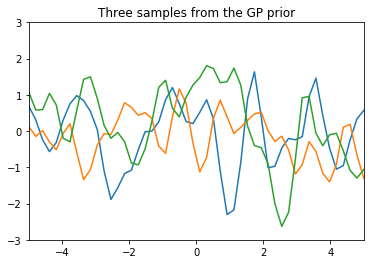

In [2]:
import numpy as np
import matplotlib.pyplot as pl

# Test data
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# Define the kernel function
def kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)



param = 0.1
K_ss = kernel(Xtest, Xtest, param)

# Get cholesky decomposition (square root) of the covariance matrix
L = np.linalg.cholesky(K_ss + 1e-15*np.eye(n)) #K=L*L.T
# Sample 3 sets of standard normals for our test points,
# multiply them by the square root of the covariance matrix
f_prior = np.dot(L, np.random.normal(size=(n,3)))

# Now let's plot the 3 sampled functions.
pl.plot(Xtest, f_prior)
pl.axis([-5, 5, -3, 3])
pl.title('Three samples from the GP prior')
pl.show()


#### Gaussian Posterior

Let's say the lables $f$ and the predicted lables $f_*$ are both normally distributed. We should also assume that $f_*$ sould be correlated to $f$. In this case, $f$ and $f_*$ could not be independant gaussians, but on could rather write it as the following:
<br/><br/>
$$ P\begin{pmatrix} f\\f_* \end{pmatrix}
{\sim} N 
\begin{pmatrix}
\begin{bmatrix} \mu \\ \mu_* \end{bmatrix},\begin{bmatrix} K_{11} & K_*  \\ K_{*}^{T} & K_{**} \end{bmatrix} 
\end{pmatrix}$$
<br/>
We use the features to calculate $K$ $K^{T}$ $K_**$ and $K_*^{T}$
<br/>
<br/>
$K$ is the self similarities of the training set
<br/>
$K_*$ is the similarities of the training set and the test set
<br/>
$K_{**}$ is the self similarities of the test set
<br/>
$f$ is known from the training data
<br/>
$f_*$ is the data we are predicting from the test data set

Remember that this is the joint prpbability, we want the conditional (the posterior), which is $P(f_*|mu_*,\Sigma_*)$ or $P(f_*|X,X_*,f)$, so that we can do predictions. The predicion is computing the posterior of $f_*$ given $f$ and the privious $X$. We are goint to derive the conditional distribution from the joint distribution $P(f_*,f)$.

We are going from 
<br/>
$$ P\begin{pmatrix} f\\f_* \end{pmatrix}
{\sim} N 
\begin{pmatrix}
\begin{bmatrix} \mu \\ \mu_* \end{bmatrix},\begin{bmatrix} K_{11} & K_*  \\ K_{*}^{T} & K_{**} \end{bmatrix} 
\end{pmatrix}$$
<br/>
to
<br/>
$$ P(f*|X_*,X,f) =  N\begin{pmatrix} f_*|\mu_*,\Sigma_* \end{pmatrix} $$
<br/>
in other words, we need to calculate the mean and the covariance, which is
<br/><br/>
$$ \mu_*= \mu(X_*)+K_*^{T}K^{-1}(f-\mu(X))$$
$$ \Sigma_*=K_{**}-K_*^{T}K^{-1}K_* $$

#### The mean tells us the mean of predicted values. The covariance tells us the uncertainty for our predicted values.
<br/><br/>

Some details in the GP regression algorithm:
$$ L=cholesky(K + \sigma^2*I)$$
$$ \alpha=L^{-T}m $$
$$ m=K^{-1}y $$
$$ E\begin{bmatrix} f_* \end{bmatrix}=k_*^{T}\alpha $$
$$ or $$
$$ E\begin{bmatrix} f_* \end{bmatrix}=k_*^{T} L^{-T}m $$
$$ or $$
$$ E\begin{bmatrix} f_* \end{bmatrix}=LK*m $$
The above equations come from the perspective of the code.

Now we look from a view of linear regresstion.

$$ f_* =k_*^{T} K_y^{-1}y $$
$$ \alpha=K_y^{-1}y $$

Thus

$$ f_* = \Sigma_{i=1}^{\infty} \alpha_i\kappa(x_i,x_*) $$

This is alpha multiplying a rbf function, if the $X$ are close to each other the kernal gives larger values. This is how the mean is calculated. which is pretty similar how linear regression works.

Source:
1. https://www.youtube.com/watch?v=4vGiHC35j9s
2. https://www.youtube.com/watch?v=MfHKW5z-OOA&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6&index=10&t=0s
3. http://katbailey.github.io/post/gaussian-processes-for-dummies/

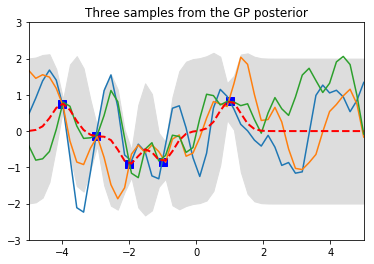

In [8]:
# Noiseless training data
Xtrain = np.array([-4, -3, -2, -1, 1]).reshape(5,1)
ytrain = np.sin(Xtrain)

# Apply the kernel function to our training points
K = kernel(Xtrain, Xtrain, param)
L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

# Compute the mean at our test points.
K_s = kernel(Xtrain, Xtest, param)
Lk = np.linalg.solve(L, K_s) # Lk=K.Tinv(L)
mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((n,)) #mu=dot(LK.T,m),   m=inv(L)*y

# Compute the standard deviation so we can plot it
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)
# Draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,3)))

pl.plot(Xtrain, ytrain, 'bs', ms=8)
pl.plot(Xtest, f_post)
pl.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
pl.plot(Xtest, mu, 'r--', lw=2)
pl.axis([-5, 5, -3, 3])
pl.title('Three samples from the GP posterior')
pl.show()

How to learn the kernel parameters? Cross validation, maximum likelihood, baysian learning

Final implementation using Scikit learn 

http://krasserm.github.io/2018/03/19/gaussian-processes/